In [182]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import glob
from PIL import Image
from sklearn import metrics, cross_validation


In [183]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'train'
TEST_PATH = 'test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
samples = [file for file in glob.glob('data/images/tmp/*.png')]
masks = [file for file in glob.glob('data/masks/tmp/*.npy')]

In [184]:
len(samples)
len(masks)

1920

In [201]:
X = np.zeros((len(samples), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for i, id_ in tqdm(enumerate(samples), total=len(samples)):
    X[i] = imread(id_)[:,:,:IMG_CHANNELS]
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = np.load('data/masks/tmp/' + os.path.basename(id_)[:-4] + '.npy')
    mask = np.expand_dims(mask_, axis=-1)
    #imshow(np.squeeze(mask))
    #plt.show()
    Y[i] = mask



Getting and resizing train images and masks ... 




  0%|          | 0/1920 [00:00<?, ?it/s]

  2%|▏         | 37/1920 [00:00<00:05, 363.87it/s]

  4%|▍         | 73/1920 [00:00<00:05, 358.50it/s]

  6%|▌         | 111/1920 [00:00<00:04, 362.83it/s]

  8%|▊         | 149/1920 [00:00<00:04, 367.03it/s]

 10%|▉         | 183/1920 [00:00<00:04, 360.66it/s]

 12%|█▏        | 222/1920 [00:00<00:04, 365.17it/s]

 14%|█▎        | 261/1920 [00:00<00:04, 367.36it/s]

 16%|█▌        | 300/1920 [00:00<00:04, 369.28it/s]

 18%|█▊        | 339/1920 [00:00<00:04, 370.82it/s]

 20%|█▉        | 378/1920 [00:01<00:04, 372.07it/s]

 22%|██▏       | 419/1920 [00:01<00:04, 374.95it/s]

 24%|██▍       | 460/1920 [00:01<00:03, 377.19it/s]

 26%|██▌       | 501/1920 [00:01<00:03, 379.35it/s]

 28%|██▊       | 541/1920 [00:01<00:03, 378.61it/s]

 30%|███       | 582/1920 [00:01<00:03, 380.33it/s]

 32%|███▏      | 622/1920 [00:01<00:03, 379.22it/s]

 34%|███▍      | 661/1920 [00:01<00:03, 379.35it/s]

 37%|███▋      | 701/1920 [00:01<00:03, 380.26it/s]

 39%

In [203]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(y_train))

1536
1536


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


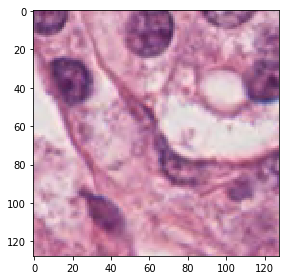

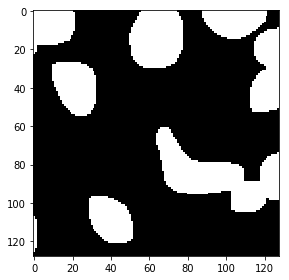

In [204]:
# Check if training data looks all right
ix = random.randint(0, len(X))
imshow(X[ix])
plt.show()
imshow(np.squeeze(Y[ix]))
plt.show()

In [205]:
# Dice coefficient
def dice_coef(y_true, y_pred):
#    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
    intersection = K.sum(y_pred * y_true)
    union = K.sum(y_pred + y_true - y_pred * y_true)
    score = 2 * intersection / (union + intersection)
    K.get_session().run(tf.local_variables_initializer())
    score = tf.identity(score)
    return score

def iou(y_true, y_pred):
    intersection = K.sum(y_pred * y_true)
    union = K.sum(y_pred + y_true) - intersection
    score = intersection / union
    K.get_session().run(tf.local_variables_initializer())
    score = tf.identity(score)
    return score

In [206]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 128, 128, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 128, 128, 8)  224         lambda_10[0][0]                  
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 128, 128, 8)  584         conv2d_172[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [208]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-5.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=4, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 1382 samples, validate on 154 samples
Epoch 1/30
1380/1382 [============================>.] - ETA: 0s - loss: 0.4755 - dice_coef: 0.5069
Epoch 00001: val_loss improved from inf to 0.36900, saving model to model-5.h5
1382/1382 [==============================] - 298s 215ms/step - loss: 0.4759 - dice_coef: 0.5070 - val_loss: 0.3690 - val_dice_coef: 0.6587
Epoch 2/30
1380/1382 [============================>.] - ETA: 0s - loss: 0.3387 - dice_coef: 0.6756
Epoch 00002: val_loss improved from 0.36900 to 0.32083, saving model to model-5.h5
1382/1382 [==============================] - 68s 49ms/step - loss: 0.3387 - dice_coef: 0.6757 - val_loss: 0.3208 - val_dice_coef: 0.7231
Epoch 3/30
1380/1382 [============================>.] - ETA: 0s - loss: 0.3172 - dice_coef: 0.6967
Epoch 00003: val_loss improved from 0.32083 to 0.30253, saving model to model-5.h5
1382/1382 [==============================] - 72s 52ms/step - loss: 0.3172 - dice_coef: 0.6968 - val_loss: 0.3025 - val_dice_coef: 0.710

In [209]:
# Predict on train, val and test
model = load_model('model-5.h5', custom_objects={'dice_coef': dice_coef})


In [210]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

384/384 [==============================] - 7s 19ms/step


In [211]:
#print(preds_test_t)
#print(Y_test.shape)
#print(K.get_session().run(K.sum(preds_test_t * Y_test)))
#print(K.get_session().run(K.sum(preds_train_t)))
#print(K.get_session().run(Y_train[:int(Y_train.shape[0]*0.9)]))
print(K.get_session().run(dice_coef(preds_train_t, tf.to_int32(y_train[:int(y_train.shape[0]*0.9)]))))
print(K.get_session().run(dice_coef(preds_val_t, tf.to_int32(y_train[int(y_train.shape[0]*0.9):]))))
print(K.get_session().run(dice_coef(preds_test_t, tf.to_int32(y_test))))

0.8606740042234744
0.8323469761251652
0.8345035533458168


In [212]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(preds_test[i])

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


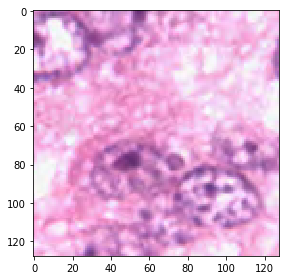

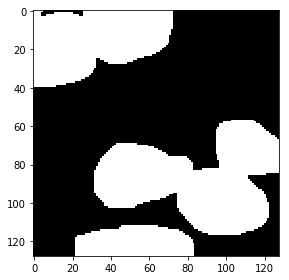

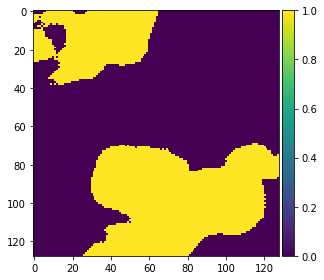

In [214]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()